정지 영상에서 객체 탐지

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# YOLO 구성 및 가중치 파일 다운로드
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true -O coco.names

--2024-03-20 06:00:13--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  22.9MB/s    in 15s     

2024-03-20 06:00:28 (16.2 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-03-20 06:00:28--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2024-03-20 06:00:29--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTTP request sent, awaiti

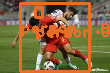

In [ ]:
# 이미지 파일을 업로드하거나 다운로드합니다.
# 예시로 사용할 이미지 파일을 직접 업로드하거나 아래 wget 명령어로 다운로드 할 수 있습니다.
# !wget <이미지 파일 URL> -O image.jpg

def load_yolo():
    net = cv.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layers_names = net.getLayerNames()
    output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    return net, classes, colors, output_layers

def load_image(img_path):
    # 이미지를 불러오고, YOLO 입력 크기로 크기를 조정합니다.
    img = cv.imread(img_path)
    img = cv.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    return img, height, width, channels

def detect_objects(img, net, outputLayers):
    blob = cv.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(outputLayers)
    return blob, outputs

def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confs.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confs, class_ids

def draw_labels(boxes, confs, colors, class_ids, classes, img):
    indexes = cv.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    font = cv.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confs[i]
            color = colors[class_ids[i]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv.putText(img, f"{label} {confidence:.2f}", (x, y + 30), font, 1, color, 2)
    cv2_imshow(img)

net, classes, colors, output_layers = load_yolo()
image, height, width, channels = load_image("soccer.jpg")

blob, outputs = detect_objects(image, net, output_layers)  # 이 부분을 수정했습니다.
boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
draw_labels(boxes, confs, colors, class_ids, classes, image)
